In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')
tf.config.LogicalDeviceConfiguration(memory_limit=1024)

LogicalDeviceConfiguration(memory_limit=1024, experimental_priority=None)

In [2]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'Food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteZ497G1/food101-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteZ497G1/food101-validation.tfrecord
Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
classes=[ds_info.features['label'].int2str(i) for i in range(101)]

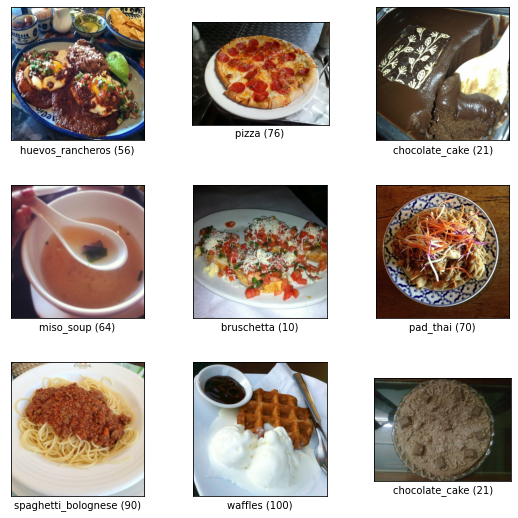

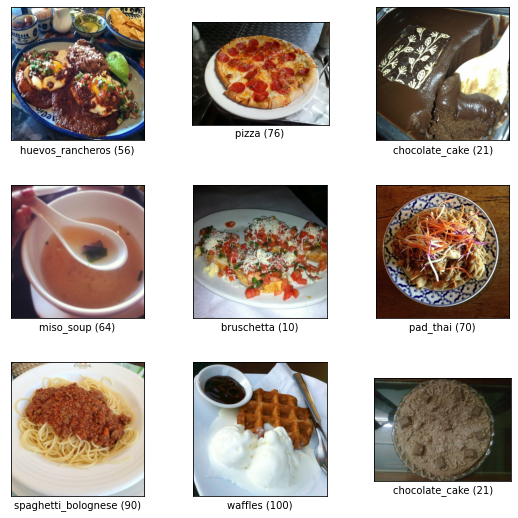

In [ ]:
tfds.show_examples(train_ds, ds_info)

In [5]:
INP_SIZE = 224
NUM_EPOCHS = 10
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
      input_shape=(INP_SIZE, INP_SIZE, 3),
      include_top=False,
      weights='imagenet',
  )

In [ ]:
weight_decay=0.01
wd=tf.keras.regularizers.L2(weight_decay)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [7]:
base_model.trainable = True

model = tf.keras.Sequential([
    data_augmentation,                         
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(500, activation='relu',kernel_regularizer=wd),
    tf.keras.layers.Dense(101, activation='softmax'),
])

In [ ]:
def scheduler(epoch, lr):
    if epoch <3 :
        return lr
    else:
        return lr * 0.9

In [8]:
ch_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=2, verbose=0,restore_best_weights=True
)

In [9]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [10]:
history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[es_callback,lr_callback,ch_callback])

Epoch 1/10
2130/2130 [==============================] - 871s 389ms/step - loss: 6.3813 - accuracy: 0.3605 - val_loss: 3.9536 - val_accuracy: 0.4833
Epoch 2/10
2130/2130 [==============================] - 815s 379ms/step - loss: 2.8845 - accuracy: 0.5689 - val_loss: 2.4434 - val_accuracy: 0.5681
Epoch 3/10
2130/2130 [==============================] - 828s 388ms/step - loss: 1.9755 - accuracy: 0.6231 - val_loss: 2.0091 - val_accuracy: 0.5881
Epoch 4/10
2130/2130 [==============================] - 827s 387ms/step - loss: 1.6056 - accuracy: 0.6609 - val_loss: 1.7754 - val_accuracy: 0.6132
Epoch 5/10
2130/2130 [==============================] - 807s 378ms/step - loss: 1.4152 - accuracy: 0.6881 - val_loss: 1.4673 - val_accuracy: 0.6724
Epoch 6/10
2130/2130 [==============================] - 826s 387ms/step - loss: 1.2928 - accuracy: 0.7070 - val_loss: 1.4338 - val_accuracy: 0.6751
Epoch 7/10
2130/2130 [==============================] - 809s 379ms/step - loss: 1.1988 - accuracy: 0.7297 - val_

Predicted class: cup_cakes
True Answer: cup_cakes


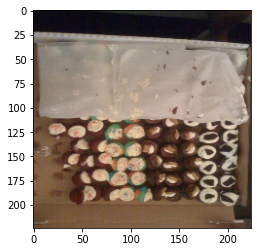

In [50]:
import random
batch=list(test_ds.take(1))[0]
idx = random.randint(0, batch[0].shape[0])
sample =  batch[0][idx]
prediction = model(np.expand_dims(sample, axis=0),  training=False)[0]
ans = np.argmax(prediction)
picture=((sample.numpy()+1)*127).astype(int)
plt.imshow(picture)
print('Predicted class: {}'.format(classes[ans]))
print('True Answer: {}'.format(classes[batch[1][idx]]))